## Determining Argument Convincingness with Limited and Generic Features
#### Jason Sanchez | 7/28/2017
#### jason.sanchez@berkeley.edu

### Abstract

Evaluating the convincingness of an argument is a task that is natural for humans, but is challenging for computers. Following previous research by Habernal and Gurevych (2016) and Chalaguine and Schulz (2017), this paper demonstrates how to determine the effectiveness of an argument through a pairwise classification task focused on identifying which of two arguments is more convincing. 

Habernal and Gurevych created the UKPConvArg1 corpus where they crowdsourced annotations for 16k pairs of arguments over 32 debate topics. They trained a 64,000 feature SVC model and a bidirectional LSTM and achieved an accuracy of .78 and .76 respectively. Chalaguine and Schulz trained a model with only thirty-five features with a .77 accuracy. Their model relied on knowing the debate topics ahead of time and having a sizable example of arguments from each topic. 

This paper demonstrates how we can train a simple ensemble model to achieve a .804 accuracy. Furthermore, only thirty-five features are used and prior knowledge of the debate topics is not required. 


### Introduction and background

Habernal and Gurevych created the UKPConvArg1 corpus where they crowdsourced annotations for 16k pairs of arguments over 32 debate topics. The arguments were scraped from an online debate website. An example of an argument pair:

|  |  |
| --- | --- |
| Argument 1 | Bottled water consumption has grown exponentially over the past ten to fifteen years. This growth has taken place globally, but particularly in Europe and North America. The bottled water industry has literally created its own water culture which is good for american industries. |
| Argument 2 | If bottled water did not exist, more people would be drinking sweetened liquids becasue it would be the only portable drinks! People would become fat! |

Groups of five human reviewers assessed the quality of each argument among 16,000 argument pairs among 32 different debate topics and recorded which argument they thought was most convincing (ties were also possible). Of these, 11,650 argument pairs remained after filtering out ties and low quality responses. See Habernal (2016) for full details of how the dataset was created.

The established evaluation metric on this dataset is group cross-validation accuracy, where each group is one of the 32 debate topics. "Accuracy" in this paper refers to this metric.

Habernal and Gurevych trained a 64,000 feature SVC model and a bidirectional LSTM and achieved an accuracy of .78 and .76 respectively. The LSTM was offered as a simpler alternative compared to the SVC with only a minor reduction in accuracy.

Chalaguine and Schulz trained a model with only thirty-five features and a .77 accuracy. Their model relied on knowing the debate topics ahead of time and having a sizable example of arguments from each topic. For example, they compared the length of each argument to the average length of an argument in the same debate topic. These groups of features were the most performant features in their model. Without using these features, their model had a .6734 accuracy.

This paper demonstrates how to achieve strong performance with thirty-five debate agnostic features using ensemble techniques. We will investigate which features were important and final model architecture.


### Methods

#### Feature engineering
Thirty-five features were created. Every feature is generic which means none depend on prior knowledge of the debate topic. Additionally, all features are comparisons between the first and second arguments. For example, the length of both arguments is calculated and the difference between these lengths is a feature used in the model.

There are three types of features:
1. **Size-based features**: Compares arguments based on the lengths of the argument text/tokens.
2. **Content-based features**: Compares arguments based on words used in the arguments.
3. **Structure-based features**: Compares arguments based on frequently occurring part-of-speech tag differences. Final features used were ones that remained after a feature selection routine that considered all 1 and 2-gram part-of-speech tags.

Importance was estimated using the mean decrease impurity from a Random Forest model trained on the entire dataset. Note, this was the only occurrence where a model was trained on all observations in the entire dataset at the same time; all other models were trained on cross-validation training folds. 

<img src="figures/feature_importances.jpeg">

Notice that several features had very small importances. These features could be excluded with little impact on final accuracy; however, they were included so future studies could get a baseline expectation of which features are useful.

We see that size-based features dominate as the most important features. This is disappointing because it means we do not know the real reason some arguments are perceived as more credible, but instead must rely on size as a proxy for other important qualities of the argument. 



#### Model architecture
Several model architectures were tested. These models ranged from a model with only one feature to a several layer ensemble model with skip layers. Ultimately, a simple model structure performed best of all model architectures tested. The chart below shows a high level picture of the model components and the accuracy of each component of the best model. RF = Random Forest, LR = Logistic Regression, KNN = K-nearest Neighbors, PT = Perceptron, MLP = Multilayer Perceptron.

<img src="figures/model_architecture.JPG">

Each individual model's out of fold predictions were used as features in the final ensemble model. By removing one model at a time, we can measure the marginal relative importance of each model in the final ensemble.

<img src="figures/model_comparisons.jpeg">

We see that most of the lift from the model comes from the features. Several of the base models have strong performance and we can get a small amount of additional lift by combining the models.



### Results and discussion
There were four previous models trained on this dataset that are of interest in the present analysis. In order of creation:
* 64k feature SVC (Habernal and Gurevych)
 * Accuracy: **.78**
 * Higher accuracy, but complex. 64,000 features were created by the authors and deep optimization was performed to tune the model.
* Bidirectional LSTM (Habernal and Gurevych)
 * Accuracy: **.76**
 * Simple to train. The network handles feature engineering. The authors consider the reduced accuracy worth the simplicity of training the model.
* Simple Neural Network - Fair Features (Chalaguine and Schulz)
 * Accuracy: **.673**
 * Of the sets of features tested, this is the results of a model trained with only features that do not require knowing the debate topics ahead of time and having access to many example arguments in each topic.
* Simple Neural Network - Debate dependent features (Chalaguine and Schulz)
 * Accuracy: **.7657**
 * Has 35 features and uses a simple feedforward neural network. The most important features are debate-specific. The model only works if the debate topic is known ahead of time and example arguments are available. 

Although many models were tested for this paper, two results are worth discussing.

The first result is that there is a simple rule that outperforms the majority of the previous models. Simply classifying the argument that has the most alphabetical letters as the most convincing argument results in 0.773 accuracy. This is better than all three neural network approaches tried in the previous papers, which counters the previous claims to prefer these models due to their simplicity. Potentially neural networks are learning too many debate specific features which hurts generalization to new topics.

The second result is that the thirty-five feature model above scored .804 which is much higher than the previous best complex model. This result was achieved with custom features and a unique model architecture. It is worth noting that one of the base models in the ensemble was a tuned neural network like that used by Chalaguine and Schulz. By itself, it was beat by tree-based models. In the ensemble, it added an exceptionally small amount of lift that would likely not make the additional complexity worth it in a production setting. 

We can graph the results of all the models. The dark columns are the models contributed by this paper. See the appendix for results by debate topic.

<img src="figures/comparisons.jpeg">


### Next steps
Clearly there is much work to do in determining the convincingness of arguments. At minimum, all future models published should have higher than the .773 accuracy from the simple rule based approach to solving the problem. 

Manually reviewing the top observations that were misclassified by the primary model (see appendix to read the top misclassified arguments) demonstrates that there are dataset labels that are clearly wrong. If this dataset is to be a core benchmark for the burgeoning field of argumentation NLP, an updated version of the dataset should be created that has more accurate labels.

Furthermore, the current dataset has more than 10k observations, but many of the individual arguments are repeated so that in a CV loop there are only ever about 950 unique arguments (versus the 21,500 unique arguments there would be if no individual arguments were repeated). The original authors do this because it allows them to rank every argument against every other argument; however, the lack of diverse arguments prevents one from performing richer analysis such identifying semantic coherence across sentences or learning generalizable argument patterns that are independent of specific topics. 

Using the currently created features might possibly result in a fully optimized model with an accuracy of around .81. Higher gains would likely require new features or significantly more sophisticated neural networks that operate on the raw text. 

A fundamental issue faced is that of background knowledge. Consider the following arguments:
1. Bottled water production will help the U.S. economy, because of the EU's stance on immigration.
2. Bottled water production will help the U.S. economy, because of the EU's stance on Notherhinge.

The first argument is nonsensical due to our background knowledge. As readers, we are able to see that the warrant of the argument does not relate to the claim being made. The second argument is identical to the first, but has a nonsense word in the place of immigration. If the reader did not know the word is a nonsense word, suddenly the argument is very difficult to evaluate as being nonsensical. Perhaps, Notherhinge is the informal name for a new bill that is relevant to bottled water production in the U.S., but perhaps it is the name of a different unrelated bill. 

This means that to truly evaluate the convincingness of an argument, we must be able to incorporate vast amounts of background knowledge into the prediction process. Unfortunately, such background knowledge is not available to machine learning models trained on only the present dataset. Future exploration that merges background knowledge (such as the Wikipedia corpus) with the present prediction task, seems to be a potentially valuable avenue of exploration.

As recognized by the other authors, this is a very difficult problem. This paper presents the current state-of-the-art, but there are significant gains to be made in the future.

### References
Federico Cerutti, Alexis Palmer, Ariel Rosenfeld, and
Francesca Toni. 2016. A pilot study in using argumentation
frameworks for online debates. Proceedings
of the First International Workshop on Systems
and Algorithms for Formal Argumentation.

Ivan Habernal and Iryna Gurevych. 2016. Which argument
is more convincing? Analyzing and predicting
convincingness of Web arguments using bidirectional
LSTM. In Proceedings of the 54th Annual Meeting
of the Association for Computational Linguistics (Volume
1: Long Papers), pages 1589–1599, Berlin, Germany.
Association for Computational Linguistics.

Isaac Persing and Vincent Ng. 2015. Modeling argument
strength in student essays. In Proceedings of the 53rd
Annual Meeting of the Association for Computational
Linguistics and the 7th International Joint Conference
on Natural Language Processing (Volume 1: Long Papers),
pages 543–552, Beijing, China. Association for
Computational Linguistics.

Ivan Habernal and Iryna Gurevych. 2017. Argumentation
Mining in User-Generated Web Discourse.
Computational Linguistics, 43(1). In press. Preprint:
http://arxiv.org/abs/1601.02403.

Jan Snajder and Filip Boltuzic. 2014. Back up your
stance: Recognising arguments in online discussions.
Proceedings of the First Workshop on Argumentation.

John Lawrence and Chris Reed. 2015. Combining argument
mining techniques. In Proceedings of the 2nd
Workshop on Argumentation Mining, pages 127–136,
Denver, CO, June. Association for Computational Linguistics.

Lisa Andreevna Chalaguine and Claudia Schulz. 2017.
Assessing Convincingness of Arguments in Online Debates 
with Limited Number of Features. Proceedings of the 
Student Research Workshop at the 15th Conference of the 
European Chapter of the Association for Computational 
Linguistics, pages 75–83

Loper, E. & Bird, S., 2002. NLTK, the Natural
Language Toolkit. In Proceedings of the ACL
Workshop on Effective Tools and Methodologies
for Teaching Natural Language Processing
and Computational Linguistics. Philadelphia:
Association for Computational Linguistics. 

Pedregosa et al. 2011. Scikit-learn: Machine Learning
in Python. Journal of Machine Learning Research (Volume
12)

<br>

# Appendix

In the interest of full transparency and reproducability, the final model is provided as part of the paper. Although this would let one reproduce the results of the paper, it makes no attempt at showing any of the techniques and attempts that didn't work.

### Model training

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from os import listdir
from nltk import word_tokenize, pos_tag, download
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.model_selection import LeaveOneGroupOut, cross_val_score, cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

download('punkt')
download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /Users/BlueOwl1/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/BlueOwl1/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

### Read in UKPConvArg1Strict data

In [2]:
path_to_compare_data_1 = "data/UKPConvArg1Strict-CSV/"

files = listdir(path_to_compare_data_1)

all_data = []

for f in files:
    path = path_to_compare_data_1 + f
    one_argument = pd.read_csv(path, sep="\t")
    one_argument["argument_group"] = f
    all_data.append(one_argument)
    
X_raw = pd.concat(all_data).reset_index(drop=True)
X_raw.head()

,#id,label,a1,a2,argument_group
0,arg219237_arg219207,a2,"jesus loves plastic water bottles, and you can...",Bottled water consumption has grown exponentia...,ban-plastic-water-bottles_no-bad-for-the-econo...
1,arg219203_arg219206,a2,The American Water companies are Aquafina (Pep...,Americans spend billions on bottled water ever...,ban-plastic-water-bottles_no-bad-for-the-econo...
2,arg219225_arg219284,a1,Banning plastic bottled water would be a huge ...,God created water bottles for a reason. Becaus...,ban-plastic-water-bottles_no-bad-for-the-econo...
3,arg219216_arg219207,a2,The water bottles are a safe source of water a...,Bottled water consumption has grown exponentia...,ban-plastic-water-bottles_no-bad-for-the-econo...
4,arg219207_arg219294,a1,Bottled water consumption has grown exponentia...,"If bottled water did not exist, more people wo...",ban-plastic-water-bottles_no-bad-for-the-econo...


In [3]:
y_raw = X_raw.pop("label")
y_raw.head()

0    a2
1    a2
2    a1
3    a2
4    a1
Name: label, dtype: object

### Create base dataset

Make y an integer, rename the arguments to use zero-based indexing to be consistent with Python, and get part-of-speech tags.

In [4]:
def sentence_tags(text):
    tags = pos_tag(word_tokenize(text))
    only_tags = [t[1] for t in tags]
    return " ".join(only_tags)

y = (y_raw == "a2").astype(int)
X = X_raw.drop(["#id"], axis=1)
X.columns = ["a0", "a1", "argument_group"]

X["a0_tags"] = X.a0.apply(sentence_tags)
X["a1_tags"] = X.a1.apply(sentence_tags)

X.head()

,a0,a1,argument_group,a0_tags,a1_tags
0,"jesus loves plastic water bottles, and you can...",Bottled water consumption has grown exponentia...,ban-plastic-water-bottles_no-bad-for-the-econo...,"NN VBZ JJ NN NNS , CC PRP VBP JJ IN DT NN",JJ NN NN VBZ VBN RB IN DT JJ NN TO VB NNS . DT...
1,The American Water companies are Aquafina (Pep...,Americans spend billions on bottled water ever...,ban-plastic-water-bottles_no-bad-for-the-econo...,"DT JJ NNP NNS VBP NNP ( NNP ) , NNP ( NNP ) , ...",NNPS VBP NNS IN JJ NN DT NN . NNP PRP$ NN MD R...
2,Banning plastic bottled water would be a huge ...,God created water bottles for a reason. Becaus...,ban-plastic-water-bottles_no-bad-for-the-econo...,NNP NN VBD NN MD VB DT JJ NN IN DT RB NN . JJR...,NNP VBD NN NNS IN DT NN . IN PRP$ JJ .
3,The water bottles are a safe source of water a...,Bottled water consumption has grown exponentia...,ban-plastic-water-bottles_no-bad-for-the-econo...,DT NN NNS VBP DT JJ NN IN NN CC VBZ JJ NN,JJ NN NN VBZ VBN RB IN DT JJ NN TO VB NNS . DT...
4,Bottled water consumption has grown exponentia...,"If bottled water did not exist, more people wo...",ban-plastic-water-bottles_no-bad-for-the-econo...,JJ NN NN VBZ VBN RB IN DT JJ NN TO VB NNS . DT...,"IN VBN NN VBD RB VB , JJR NNS MD VB VBG JJ NNS..."


In [5]:
y.head()

0    1
1    1
2    0
3    1
4    0
Name: label, dtype: int64

### Create a clean base dataset

Because all feature transformations are stateless, we can apply them outside of the CV loop without leaking any signal from the holdout datasets.

In [6]:
transition_words = set(['similarly', 'foremost', 'presumably', 'moreover', 'however', 'reason', 'otherwise', 'second,', 'still', 'first', 'even', 'ultimately', 'finally', 'therefore', 'addition', 'next', 'also', 'furthermore', 'conclusion', 'third', 'hand', 'another'])
misspelled_words = set(['wouldn', 'dont', 'shouldn', 'india', 'firefox', 'didn', 'wouldnt', 'doesnt', 'thier', 'farquhar', 'couldn', 'commited', 'adam', 'theyre', 'sabrejimmy', 'persuit', 'definately', 'shouldnt', 'marrage', 'syona', 'alot', 'beleive', 'donot', 'commen', 'especialy', 'dicipline', 'arguement', 'likley', 'lously', 'havn', 'alcohlic', 'wasnt', 'aint', 'bcoz', 'hace', 'decir', 'planta', 'politian', 'acomplice', 'definetly', 'incestual', 'chasbas', 'soooo', 'coolio', 'hoolio', 'infront', 'creatoinism', 'enviroment', 'hasn', 'becasue', 'farquer', 'xada', 'atrever', 'menos', 'dathu', 'ihfej', 'humano', 'charector', 'blimem', 'shld', 'urself', 'tijkjdrk', 'sholud', 'jarman', 'responsibilily', 'preverted', 'plantas', 'aunque', 'sayin', 'xadgeno', 'imformation', 'xbanico', 'sfjiiytg', 'negleted', 'chupar', 'guil', 'xtklp', 'incharge', 'telvisions', 'telivision', 'igual', 'recursos', 'ushould', 'thik', 'supress', 'querido', 'idioma', 'unforms', 'unatrel', 'cauntious', 'evrybdy', 'bookxx', 'beleifs', 'eles', 'completly', 'isnot', 'beleave', 'beter', 'llaman', 'wdout', 'smoken', 'facr', 'illegaly', 'nowadayz', 'doont', 'somkers', 'somke', 'responsiblity', 'homosapien', 'dissappointed', 'criterium', 'hets', 'doughter', 'posible', 'strategizing', 'succeful', 'probaly', 'atleast', 'beileve', 'vida', 'pero', 'mench', 'playstations', 'niega', 'importhant', 'pensar', 'sentir', 'puede', 'aslong', 'ciggarettes', 'sooooooo', 'ebil', 'sito', 'botherd', 'diegnosedca', 'humanos', 'animales', 'suelen', 'aborto', 'matar', 'bullsh', 'employe', 'evryone', 'benifit', 'enviorment', 'lookin', 'persue', 'diffenrent', 'embroyo', 'undertsand', 'interveiw', 'becouse', 'afterschool', 'diferent', 'highschool', 'alreaddy', 'leagal', 'unpetty', 'themselfs', 'yoursel', 'defenceless', 'absolutley', 'peices', 'advencing', 'isnt', 'inequal', 'instinc', 'succesful', 'insctinc', 'disapointment', 'organisation', 'beemed', 'succeded', 'woulld', 'excuss', 'chil', 'singapura', 'majulah', 'mothernature', 'wannna', 'compulsaryy', 'preggo', 'weren', 'dieases', 'relize', 'coloured', 'actualy', 'expirience', 'itll', 'obecity', 'personhood', 'dosent', 'clases', 'mandortory', 'excersise', 'whloe', 'manditory', 'howzz', 'definatley', 'expirence', 'benifits', 'licence', 'echoworld', 'lieing', 'othr', 'alow', 'overal', 'theri', 'stoping', 'selfes', 'becoz', 'mmorning', 'mustn', 'espeacilly', 'perfomed', 'exersises', 'thankyou', 'dreamt', 'theirself', 'cuhz', 'learnt', 'malay', 'proble', 'wether', 'newscientist', 'evealution', 'makind', 'beleivers', 'argumentum', 'populum', 'extreamly', 'callad', 'beleives', 'scientologists', 'aquire', 'existance', 'addons', 'fanboy', 'realeased', 'wayyyyy', 'pointlessss', 'enititys', 'microsot', 'stylesheets', 'google', 'toolbar', 'phro', 'tohttp', 'evol', 'dinosauria', 'neccisary', 'varifiable', 'usgs', 'envirnment', 'nuff', 'polandspring', 'aspx', 'duboard', 'criters', 'worryz', 'excrament', 'produceing', 'evironment', 'poluted', 'healthywater', 'hypocryte', 'friendsjournal', 'garentee', 'compostable', 'youre', 'serval', 'comfortabley', 'suply', 'nikawater', 'nestlewaterscorporate', 'equis', 'ditrabutions', 'treehugger', 'extremly', 'weve', 'aynrandlexicon', 'flipppin', 'belivers', 'religon', 'biggots', 'athieists', 'besause', 'indepent', 'healp', 'lawl', 'sunday', 'spamming', 'therfore', 'recognise', 'simplier', 'didnt', 'xafsm', 'disputs', 'superbrain', 'politians', 'hitech', 'illitrate', 'literated', 'enought', 'specialy', 'fricken', 'opressed', 'illeteracy', 'toughy', 'somone', 'muder', 'marrie', 'sombody', 'accompalice', 'incase', 'hurst', 'basicly', 'preffer', 'nothong', 'tounges', 'contries', 'forgeting', 'ndians', 'hardwork', 'languags', 'utillised', 'prsns', 'ptential', 'manufactoring', 'dependant', 'alawys', 'violance', 'dissapointed', 'tought', 'figuer', 'msitake', 'arent', 'ooooooooh', 'sush', 'differnce', 'wats', 'aryabhatta', 'chatng', 'debatng', 'partical', 'pottential', 'nuissance', 'nalanda', 'jagah', 'achcha', 'hamara', 'britishers', 'orginal', 'americans', 'rama', 'krishna', 'vishvamitr', 'vishvguru', 'francisco', 'nutjobes', 'certainley', 'needn', 'roomates', 'marraige', 'secuality', 'respecful', 'harrassed', 'veiws', 'centry', 'commiting', 'beacuse', 'adware', 'nobrob', 'enuff', 'preinstall', 'derrrr', 'imho', 'weatherfox', 'apps', 'novanet', 'perfrom', 'popup', 'avaible', 'tooltip', 'spaking', 'saame', 'butthole', 'belifs', 'eachother', 'hackman', 'involed', 'throught', 'defence', 'worng', 'couldnt', 'reponsiblity', 'wong', 'woppen', 'nessasary', 'prenup', 'becuase', 'liklihood', 'couse', 'contriverse', 'accomodate', 'extrem', 'pepole', 'accomodations', 'sucied', 'wakoness', 'absoultly'])
slang_words = set(['creep', 'jerk', 'basic', 'wicked', 'diss', 'props', 'unreal', 'dig', 'ripped', 'swole', 'wrecked', 'wasted', 'busted', 'awesome', 'trip', 'cool', 'chilling', 'chill', 'amped', 'blast', 'crush', 'dump', 'geek', 'sick', 'toasted', 'fail', 'epic', 'dunno', 'loser', 'rip', 'off', 'beat', 'bling', 'break', 'cheesy', 'cop', 'out', 'da', 'bomb', 'dope', 'downer', 'fab', 'flake', 'freak', 'disgusting', 'hooked', 'fleet', 'flawless', 'snatched', 'shorty', 'grill', 'hustle', 'grind', 'beef', 'fresh', 'word', 'wack', 'def', 'skeeze', 'ill', 'dough', 'mooch', 'boo', 'baller', 'bromance', 'dawg', 'dude', 'lol', 'ratchet', 'selfie', 'sweet', 'woke', 'neat', 'kidding', 'agame', 'bro', 'cash', 'cop', 'hip', 'jacked', 'hype', 'score', 'trash', 'riled', 'pissed', 'bummer', 'check', 'dead', 'totes'])
important_parts_of_speech = ["vbp", "vbp prp", "nn nn", "to", "dt", "dt nn", "cc"]


def n_general_transitions(x):
    words = x.split()
    total = 0
    for w in words:
        if w in transition_words:
            total += 1
    return total


def n_misspelled_words(x):
    words = x.split()
    total = 0
    for w in words:
        if w in misspelled_words:
            total += 1
    return total


def n_slang_words(x):
    words = x.split()
    total = 0
    for w in words:
        if w in slang_words:
            total += 1
    return total


def percent_unique(x):
    words = x.split()
    unique = set(words)
    percent_unique = len(unique)/len(words)
    return percent_unique


def word_length_variability(x):
    words = x.split()
    lengths = []
    for word in words:
        lengths.append(len(word))
    return np.array(lengths).std()


def percent_one_letter_words(x):
    words = x.split()
    counts = 0
    for word in words:
        if len(word) == 1: counts += 1
    return counts/len(words)


class TextBasedFeatures(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y):
        return self
    
    def transform(self, X, y=None):
        X = X.copy()
        a0_raw = X.a0
        a1_raw = X.a1
        a0_simple = a0_raw.str.lower().str.replace("[^a-zA-Z ]", "")
        a1_simple = a1_raw.str.lower().str.replace("[^a-zA-Z ]", "")
        a0 = a0_simple.str
        a1 = a1_simple.str
        
        # a0 features
        X["characters_a0"] = a0.len()
        X["pronoun_counts_a0"] = a0.count(" you ") + a0.count(" i ") + a0.count(" me ") + a0.count(" my ")
        X["certain_lang_counts_a0"] = a0.count(" always ") + a0.count(" never ") + a0.count(" impossible ")
        X["uncertain_lang_counts_a0"] = a0.count(" believe ") + a0.count(" think ") + a0.count(" feel ")
        X["bold_counts_a0"] = a0_raw.str.count("<br/>")
        X["because_counts_a0"] = a0_raw.str.count("because")
        X["quote_counts_a0"] = a0_raw.str.count("[\"']")
        X["comma_counts_a0"] = a0_raw.str.count(",")
        X["words_a0"] = a0.count(" ") + 1
        X["total_punctuation_a0"] = a0_raw.str.count("[.,?$!:;'\"-]")
        X["punctuation_percent_a0"] = X["total_punctuation_a0"]/X["characters_a0"]
        X["end_of_sentence_punct_counts_a0"] = a0_raw.str.count("[!?.][ \n]")
        X["no_sentence_punctuation_a0"] = (X["end_of_sentence_punct_counts_a0"]==0).astype(int)
        X["sentence_counts_a0"] = X["end_of_sentence_punct_counts_a0"] + X["no_sentence_punctuation_a0"]
        X["average_sentence_word_len_a0"] = X["words_a0"]/X["sentence_counts_a0"]
        X["average_sentence_char_len_a0"] = X["characters_a0"]/X["sentence_counts_a0"]
        X["average_word_length_a0"] = X["characters_a0"]/X["words_a0"]
        X["n_transitions_a0"] = a0_simple.apply(n_general_transitions)
        X["n_misspelled_a0"] = a0_simple.apply(n_misspelled_words)
        X["n_slang_words_a0"] = a0_simple.apply(n_slang_words)
        X["percent_words_unique_a0"] = a0_simple.apply(percent_unique)
        X["first_word_capitalized_a0"] = a0_raw.apply(lambda x: x[0].isupper()*1)
        X["n_proper_nouns_a0"] = a0_raw.str.count("[^.!?;] [A-Z]")
        X["all_caps_words_a0"] = a0_raw.str.count("[A-Z]+[ .!?]")
        X["n_digits_a0"] = a0_raw.apply(lambda x: sum(1 for c in x if c.isdigit()))
        X["vbp_a0"] = X.a0_tags.str.count("VBP")
        X["vbp_prp_a0"] = X.a0_tags.str.count("VBP PRP")
        X["nn_nn_a0"] = X.a0_tags.str.count("NN NN")
        X["to_a0"] = X.a0_tags.str.count("TO")
        X["dt_a0"] = X.a0_tags.str.count("DT")
        X["dt_nn_a0"] = X.a0_tags.str.count("DT NN")
        X["cc_a0"] = X.a0_tags.str.count("CC")
        X["word_len_var_a0"] = a0_simple.apply(word_length_variability)
        X["perc_one_letter_a0"] = a0_simple.apply(percent_one_letter_words)

        # a1 features
        X["characters_a1"] = a1.len()
        X["pronoun_counts_a1"] = a1.count(" you ") + a1.count(" i ") + a1.count(" me ") + a1.count(" my ")
        X["certain_lang_counts_a1"] = a1.count(" always ") + a1.count(" never ") + a1.count(" impossible ")
        X["uncertain_lang_counts_a1"] = a1.count(" believe ") + a1.count(" think ") + a1.count(" feel ")
        X["bold_counts_a1"] = a1_raw.str.count("<br/>")
        X["because_counts_a1"] = a1_raw.str.count("because")
        X["quote_counts_a1"] = a1_raw.str.count("[\"']")
        X["comma_counts_a1"] = a1_raw.str.count(",")
        X["words_a1"] = a1.count(" ") + 1
        X["total_punctuation_a1"] = a1_raw.str.count("[.,?$!:;'\"-]")
        X["punctuation_percent_a1"] = X["total_punctuation_a1"]/X["characters_a1"]
        X["end_of_sentence_punct_counts_a1"] = a1_raw.str.count("[!?.][ \n]")
        X["no_sentence_punctuation_a1"] = (X["end_of_sentence_punct_counts_a1"]==0).astype(int)
        X["sentence_counts_a1"] = X["end_of_sentence_punct_counts_a1"] + X["no_sentence_punctuation_a1"]
        X["average_sentence_word_len_a1"] = X["words_a1"]/X["sentence_counts_a1"]
        X["average_sentence_char_len_a1"] = X["characters_a1"]/X["sentence_counts_a1"]
        X["average_word_length_a1"] = X["characters_a1"]/X["words_a1"]
        X["n_transitions_a1"] = a1_simple.apply(n_general_transitions)
        X["n_misspelled_a1"] = a1_simple.apply(n_misspelled_words)
        X["n_slang_words_a1"] = a1_simple.apply(n_slang_words)
        X["percent_words_unique_a1"] = a1_simple.apply(percent_unique)
        X["first_word_capitalized_a1"] = a1_raw.apply(lambda x: x[0].isupper()*1)
        X["n_proper_nouns_a1"] = a1_raw.str.count("[^.!?;] [A-Z]")
        X["all_caps_words_a1"] = a1_raw.str.count("[A-Z]+[ .!?]")
        X["n_digits_a1"] = a1_raw.apply(lambda x: sum(1 for c in x if c.isdigit()))
        X["vbp_a1"] = X.a1_tags.str.count("VBP")
        X["vbp_prp_a1"] = X.a1_tags.str.count("VBP PRP")
        X["nn_nn_a1"] = X.a1_tags.str.count("NN NN")
        X["to_a1"] = X.a1_tags.str.count("TO")
        X["dt_a1"] = X.a1_tags.str.count("DT")
        X["dt_nn_a1"] = X.a1_tags.str.count("DT NN")
        X["cc_a1"] = X.a1_tags.str.count("CC")
        X["word_len_var_a1"] = a1_simple.apply(word_length_variability)
        X["perc_one_letter_a1"] = a1_simple.apply(percent_one_letter_words)
        
        # diff features
        X["character_diff"] = X["characters_a0"] - X["characters_a1"]
        X["character_diff_percent"] = X["character_diff"]/X["characters_a1"]
        X["pronoun_count_diff"] = X["pronoun_counts_a0"] - X["pronoun_counts_a1"]
        X["certain_language_diff"] = X["certain_lang_counts_a0"] - X["certain_lang_counts_a1"]
        X["uncertain_language_diff"] = X["uncertain_lang_counts_a0"] - X["uncertain_lang_counts_a1"]
        X["bold_counts_diff"] = X["bold_counts_a0"] - X["bold_counts_a1"]
        X["because_counts_diff"] = X["because_counts_a0"] - X["because_counts_a1"]
        X["quote_counts_diff"] = X["quote_counts_a0"] - X["quote_counts_a1"]
        X["comma_counts_diff"] = X["comma_counts_a0"] - X["comma_counts_a1"]
        X["words_diff"] = X["words_a0"] - X["words_a1"]
        X["words_diff_percent"] = X["words_diff"]/X["words_a1"]
        X["punctuation_percent_diff"] = X["punctuation_percent_a0"] - X["punctuation_percent_a1"]
        X["punctuation_percent_diff_percent"] = X["punctuation_percent_diff"]/(X["punctuation_percent_a1"] + 1)
        X["sentence_diff"] = X["sentence_counts_a0"] - X["sentence_counts_a1"]
        X["average_sentence_word_len_diff"] = X["average_sentence_word_len_a0"] - X["average_sentence_word_len_a1"]
        X["average_sentence_char_len_diff"] = X["average_sentence_char_len_a0"] - X["average_sentence_char_len_a1"]
        X["average_word_length_diff"] = X["average_word_length_a0"] - X["average_word_length_a1"]
        X["average_word_length_diff_percent"] = X["average_word_length_diff"]/X["average_word_length_a1"]
        X["n_transitions_diff"] = X["n_transitions_a0"] - X["n_transitions_a1"]
        X["n_misspelled_diff"] = X["n_misspelled_a0"] - X["n_misspelled_a1"]
        X["n_slang_diff"] = X["n_slang_words_a0"] - X["n_slang_words_a1"]
        X["percent_words_unique_diff"] = X["percent_words_unique_a0"] - X["percent_words_unique_a1"]
        X["first_word_cap_diff"] = X["first_word_capitalized_a0"] - X["first_word_capitalized_a1"]
        X["n_proper_nouns_diff"] = X["n_proper_nouns_a0"] - X["n_proper_nouns_a1"]
        X["all_caps_words_diff"] = X["all_caps_words_a0"] - X["all_caps_words_a1"]
        X["n_digits_diff"] = X["n_digits_a0"] - X["n_digits_a1"]
        X["vbp_diff"] = X["vbp_a0"] - X["vbp_a1"]
        X["vbp_prp_diff"] = X["vbp_prp_a0"] - X["vbp_prp_a1"]
        X["nn_nn_diff"] = X["nn_nn_a0"] - X["nn_nn_a1"]
        X["to_diff"] = X["to_a0"] - X["to_a1"]
        X["dt_diff"] = X["dt_a0"] - X["dt_a1"]
        X["dt_nn_diff"] = X["dt_nn_a0"] - X["dt_nn_a1"]
        X["cc_diff"] = X["cc_a0"] - X["cc_a1"]
        return X

    
class KeepNumeric(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        self.numeric_columns = X.dtypes[X.dtypes != "object"].index.tolist()
        return self
        
    def transform(self, X, y=None):
        return X[self.numeric_columns]

    
class OnlyDiffs(BaseEstimator, TransformerMixin):
    def __init__(self, on=True):
        self.on = on
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        if self.on:
            diff_cols = [c for c in X.columns if "diff" in c]
            other_cols = ["a0_tags", "a1_tags"]
            return X[diff_cols+other_cols]
        else:
            return X
    

class ColNames(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        self.columns = X.columns
        return self
    
    def transform(self, X):
        return X
    
    
def accuracy(y, y_hat, threshold=.5):
    if (len(y_hat.shape) == 2) and (y_hat.shape[1] == 2):
        y_hat = y_hat[:,1]
    return accuracy_score(y, y_hat>threshold)


# Create cross-validation folds that are based on argument groups
group_cv = LeaveOneGroupOut()
group_cv.get_n_splits(X, y, X.argument_group)

# Apply feature transformations and create clean dataset
steps = [("simple_features", TextBasedFeatures()),
         ("only_diff_columns", OnlyDiffs(on=True)),
         ("keep_numeric_only", KeepNumeric()),
         ("col_names", ColNames())]

pipe = Pipeline(steps)

X_clean = pipe.fit_transform(X, y)
X_clean.head()

,character_diff,character_diff_percent,pronoun_count_diff,certain_language_diff,uncertain_language_diff,bold_counts_diff,because_counts_diff,quote_counts_diff,comma_counts_diff,words_diff,...,n_proper_nouns_diff,all_caps_words_diff,n_digits_diff,vbp_diff,vbp_prp_diff,nn_nn_diff,to_diff,dt_diff,dt_nn_diff,cc_diff
0,-207,-0.752727,1,0,0,0,0,0,0,-31,...,-3,0,0,1,0,-2,-1,-3,0,-1
1,-533,-0.817485,0,0,0,-1,0,0,-3,-82,...,5,0,0,-2,0,-3,-4,-9,-6,-4
2,553,10.054545,0,0,0,1,0,0,1,86,...,7,2,12,2,0,3,1,13,6,4
3,-208,-0.756364,0,0,0,0,0,0,-1,-30,...,-3,0,0,1,0,-2,-1,-2,0,-1
4,128,0.870748,0,0,0,0,0,0,0,18,...,3,0,0,0,0,3,1,3,1,2


### Feature importances

When calculating feature importances, we make max_features 1 so that all features independently have a chance to contribute to the model. 

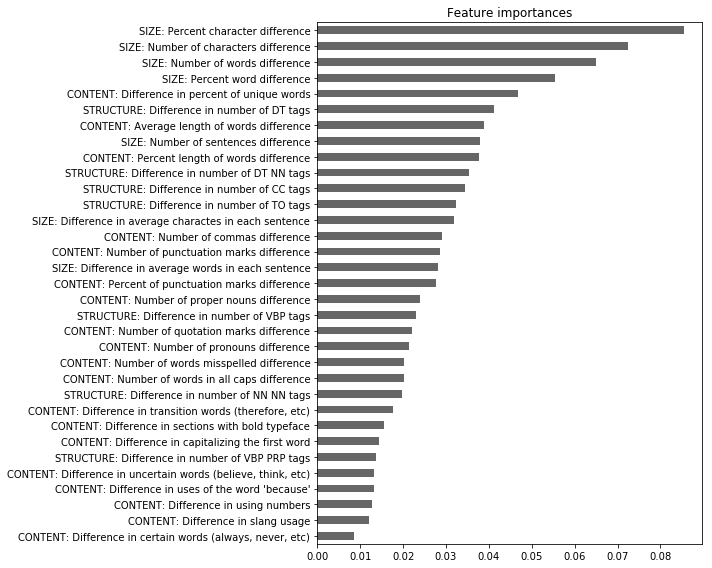

In [7]:
column_names = {
    "character_diff_percent":"SIZE: Percent character difference",
    "character_diff":"SIZE: Number of characters difference",
    "words_diff":"SIZE: Number of words difference",
    "words_diff_percent":"SIZE: Percent word difference",
    "percent_words_unique_diff":"CONTENT: Difference in percent of unique words",
    "dt_diff":"STRUCTURE: Difference in number of DT tags", 
    "average_word_length_diff":"CONTENT: Average length of words difference",
    "sentence_diff":"SIZE: Number of sentences difference",
    "average_word_length_diff_percent":"CONTENT: Percent length of words difference",
    "dt_nn_diff":"STRUCTURE: Difference in number of DT NN tags",
    "cc_diff":"STRUCTURE: Difference in number of CC tags",
    "to_diff":"STRUCTURE: Difference in number of TO tags",
    "average_sentence_char_len_diff":"SIZE: Difference in average charactes in each sentence",
    "comma_counts_diff":"CONTENT: Number of commas difference",
    "punctuation_percent_diff":"CONTENT: Number of punctuation marks difference",
    "average_sentence_word_len_diff":"SIZE: Difference in average words in each sentence",
    "punctuation_percent_diff_percent":"CONTENT: Percent of punctuation marks difference",
    "n_proper_nouns_diff":"CONTENT: Number of proper nouns difference",
    "vbp_diff":"STRUCTURE: Difference in number of VBP tags",
    "quote_counts_diff":"CONTENT: Number of quotation marks difference",
    "pronoun_count_diff":"CONTENT: Number of pronouns difference",
    "n_misspelled_diff":"CONTENT: Number of words misspelled difference",
    "all_caps_words_diff":"CONTENT: Number of words in all caps difference",
    "nn_nn_diff":"STRUCTURE: Difference in number of NN NN tags",
    "n_transitions_diff":"CONTENT: Difference in transition words (therefore, etc)",
    "bold_counts_diff":"CONTENT: Difference in sections with bold typeface",
    "first_word_cap_diff":"CONTENT: Difference in capitalizing the first word",
    "vbp_prp_diff":"STRUCTURE: Difference in number of VBP PRP tags",
    "uncertain_language_diff":"CONTENT: Difference in uncertain words (believe, think, etc)",
    "because_counts_diff":"CONTENT: Difference in uses of the word 'because'",
    "n_digits_diff": "CONTENT: Difference in using numbers",
    "n_slang_diff": "CONTENT: Difference in slang usage",
    "certain_language_diff": "CONTENT: Difference in certain words (always, never, etc)"
}

clean_columns = [column_names[column] for column in X_clean.columns.values]

rf_imp = RandomForestClassifier(n_estimators=100, max_features=1,
                                n_jobs=-1,
                                random_state=42)
rf_imp.fit(X_clean, y)

feature_importances = pd.Series(rf_imp.feature_importances_, index=clean_columns)
feature_importances.sort_values(inplace=True)
feature_importances.plot(kind="barh", figsize=(10,8), color=".4")
plt.title("Feature importances")
plt.tight_layout()
plt.savefig("figures/feature_importances.jpeg")

### One rule model

This is the accuracy of the "model" that is simply the rule to pick the argument with the most letters in it.

In [8]:
print(accuracy(y, X_clean[["character_diff"]] <= 0))

0.77339055794


### Ensemble model

In [9]:
%%time

rf = RandomForestClassifier(n_estimators=1000,
                            n_jobs=-1,
                            random_state=42)

rf_predictions = cross_val_predict(rf, 
                                   X_clean, 
                                   y, 
                                   cv=group_cv, 
                                   groups=X.argument_group, 
                                   n_jobs=-1, 
                                   method='predict_proba')[:,1]

print(accuracy(y, rf_predictions))

0.798454935622
Wall time: 2min 2s


In [10]:
%%time

scale = StandardScaler()
lr = LogisticRegression(C=0.00125, random_state=42)
lr_pipe = Pipeline([("scale", scale), 
                    ("model", lr)])

lr_predictions = cross_val_predict(lr_pipe, 
                                   X_clean, 
                                   y, 
                                   cv=group_cv, 
                                   groups=X.argument_group, 
                                   n_jobs=-1, 
                                   method='predict_proba')[:,1]
print(accuracy(y, lr_predictions))

0.794935622318
Wall time: 5.52 s


In [11]:
%%time

knn = KNeighborsClassifier(n_neighbors=35, n_jobs=-1)
scale_knn = StandardScaler()

knn_pipe = Pipeline([("scale", scale_knn), 
                     ("model", knn)])

knn_predictions = cross_val_predict(knn_pipe, 
                                    X_clean, 
                                    y, 
                                    cv=group_cv, 
                                    groups=X.argument_group, 
                                    n_jobs=-1, 
                                    method='predict_proba')[:,1]
print(accuracy(y, knn_predictions))

0.776995708155
Wall time: 7.11 s


In [12]:
%%time

pt = Perceptron(random_state=42, n_jobs=-1)
scale_pt = StandardScaler()

pt_pipe = Pipeline([("scale", scale_pt), 
                     ("model", pt)])

pt_predictions = cross_val_predict(pt_pipe, 
                                    X_clean, 
                                    y, 
                                    cv=group_cv, 
                                    groups=X.argument_group, 
                                    n_jobs=-1, 
                                    method='predict')
print(accuracy(y, pt_predictions))

0.736995708155
Wall time: 5.11 s


In [13]:
%%time

best_params = {
    'alpha': 0.0001,
    'beta_1': 0.94,
    'hidden_layer_sizes': (10, 6),
    'learning_rate_init': 0.002}

mlp = MLPClassifier(random_state=42, **best_params)

scale_mlp = StandardScaler()

mlp_pipe = Pipeline([("scale", scale_mlp), 
                     ("model", mlp)])

mlp_predictions = cross_val_predict(mlp_pipe, 
                                    X_clean, 
                                    y, 
                                    cv=group_cv, 
                                    groups=X.argument_group, 
                                    n_jobs=-1, 
                                    method='predict_proba')[:,1]
print(accuracy(y, mlp_predictions))

0.785321888412
Wall time: 18.8 s


Layer one ensemble

In [14]:
X_ens_1 = pd.DataFrame()
X_ens_1["rf"] = rf_predictions
X_ens_1["lr"] = lr_predictions
X_ens_1["knn"] = knn_predictions
X_ens_1["pt"] = pt_predictions
X_ens_1["mlp"] = mlp_predictions

In [15]:
%%time

lr = LogisticRegression(C=0.5, random_state=42)

lr_ens_1_predictions = cross_val_predict(lr, 
                                   X_ens_1, 
                                   y, 
                                   cv=group_cv, 
                                   groups=X.argument_group, 
                                   n_jobs=-1, 
                                   method='predict_proba')[:,1]
ensemble_score = accuracy(y, lr_ens_1_predictions)
print(ensemble_score)

0.804034334764
Wall time: 4.94 s


### Group results

In [16]:
group_results = pd.DataFrame()
group_results["y_hat"] = lr_ens_1_predictions
group_results["y"] = y
group_results.groupby(X.argument_group).apply(lambda x: accuracy(x.y, x.y_hat)).round(2)

argument_group
ban-plastic-water-bottles_no-bad-for-the-economy.csv                                                0.87
ban-plastic-water-bottles_yes-emergencies-only.csv                                                  0.92
christianity-or-atheism-_atheism.csv                                                                0.81
christianity-or-atheism-_christianity.csv                                                           0.74
evolution-vs-creation_creation.csv                                                                  0.88
evolution-vs-creation_evolution.csv                                                                 0.67
firefox-vs-internet-explorer_it-has-a-cute-logo-oh-and-extensions-err-add-ons.csv                   0.84
firefox-vs-internet-explorer_there-s-more-browsers-than-the-ie-firefox-is-an-animal.csv             0.84
gay-marriage-right-or-wrong_allowing-gay-marriage-is-right.csv                                      0.79
gay-marriage-right-or-wrong_allowing-gay

### Evaluating model marginal contributions

In [18]:
%%time

results = {}

for model_to_drop in X_ens_1.columns:
    X_ens_1_temp = X_ens_1.copy()
    X_ens_1_temp = X_ens_1_temp.drop([model_to_drop], axis=1)

    lr = LogisticRegression(C=0.5, random_state=42)

    lr_ens_1_predictions = cross_val_predict(lr, 
                                       X_ens_1_temp, 
                                       y, 
                                       cv=group_cv, 
                                       groups=X.argument_group, 
                                       n_jobs=-1, 
                                       method='predict_proba')[:,1]
    score = accuracy(y, lr_ens_1_predictions)
    lift = ensemble_score - score
    results[model_to_drop] = lift

Wall time: 24.3 s


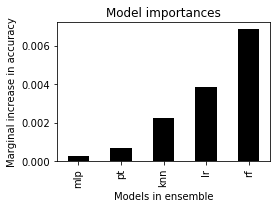

In [19]:
pd.Series(results).sort_values().plot("bar", figsize=(4,3), color="k")
plt.title("Model importances")
plt.xlabel("Models in ensemble")
plt.ylabel("Marginal increase in accuracy")
plt.tight_layout()
plt.savefig("figures/model_comparisons.jpeg")

### Largest model errors

In [20]:
pd.options.display.max_colwidth = 1000

errors = (y - lr_ens_1_predictions).sort_values()
false_positives = errors[:10].index
false_negatives = errors[-10:].index
X_assess = X_raw.copy()
X_assess["target"] = y_raw
X_assess.iloc[false_positives]

,#id,a1,a2,argument_group,target
8525,arg33146_arg33102,Personal pursuit is better in my opinion. How are you going to reach common good if you cant better yourself. People may see that as being selfish but you cant help others if you cant help yourself.,"Unfortunately it is human nature to be selfish. This doesn't always mean that you are going to be a mean person and always do what is best for you, but an individual will usually help himself first. Sometimes in a good situation going out on your own personal pursuit does advance the common good. Neither is necessarily better but I believe that a personal pursuit might be more useful we only live this life for so long and we want to be the best we can be. Maybe your personal pursuit is to advance the common good.",personal-pursuit-or-advancing-the-common-good-_personal-pursuit.csv,a1
1842,29310_780,all i have to say on this issue is that there is actual evidence to support evolution!!,"What - is God coming in the year 2100 to judge us then? Not in 2000? <br/> Why would God have to tweak anyhow. The guy is all-powerful. So he created some single-celled organisms billions of years ago, and then said to himself ""I'm going to set this thing called evolution going and see what happens. Yes, I'll tweak these tiny organisms a bit. Then maybe humans will evolve some day and I can make Mary give birth to Jesus."" <br/> Yes, that all makes a lot of sense. A good use of God's time.",evolution-vs-creation_evolution.csv,a1
247,arg219203_arg219298,"The American Water companies are Aquafina (Pepsi), Dasani (Coke), Perrier (Nestle) which provide jobs for the american citizens,","In 2006, the Alliance for a Healthier Generation and the American Beverage Association worked together to develop a set of National School Beverage Guidelines. This was prepared to reduce the calories delivered to schools by beverage companies and in return promote healthier school choices for children. The articles illustrate the program and significant results thus far. Since its inception there has been a 58% cut in total calories contained in all beverages shipped to schools. Further, a survey was taken of parents, pediatricians and family physicians. The highest supported choice for each group was bottled water. (http://www.nikawater.org/bottled-water/ )",ban-plastic-water-bottles_no-bad-for-the-economy.csv,a1
7489,arg284049_arg238471,students should wear what they like and feel free about their clothes,"I take the view that, school uniform is very comfortable. Because there is the gap between the rich and poor, school uniform is efficient in many ways. If they wore to plain clothes every day, they concerned about clothes by brand and quantity of clothes. Every teenager is sensible so the poor students can feel inferior. Although school uniform is very expensive , it is cheap better than plain clothes. Also they feel sense of kinship and sense of belonging. In my case, school uniform is convenient. I don't have to worry about my clothes during my student days.",is-the-school-uniform-a-good-or-bad-idea-_bad.csv,a1
7370,arg336277_arg238471,the kids lose their individuality and it doesn't feel comfortable,"I take the view that, school uniform is very comfortable. Because there is the gap between the rich and poor, school uniform is efficient in many ways. If they wore to plain clothes every day, they concerned about clothes by brand and quantity of clothes. Every teenager is sensible so the poor students can feel inferior. Although school uniform is very expensive , it is cheap better than plain clothes. Also they feel sense of kinship and sense of belonging. In my case, school uniform is convenient. I don't have to worry about my clothes during my student days.",is-the-school-uniform-a-good-or-bad-idea-_bad.csv,a1
7494,arg198296_arg238468,It is in not comfortable when you sit for an hours in a classroom.,"I have always maintained that it is a good idea to wear a uniform to school. Why not? because it looks very n

In [21]:
X_assess = X_raw.copy()
X_assess["target"] = y_raw
X_assess.iloc[false_negatives]

,#id,a1,a2,argument_group,target
1171,arg229582_arg644073,"Atheists rely on proof even though they have none... So if my religion has no proof so that gives your religion proof atheists? Makes no sense. Where atheists have nothing to back themselves up with, when Christians do. And the thing they have to back themselves up with is the Bible, what do the atheists have? Evolution? Everyone knows evolution is a load of crap.",Christianity does offer hope in the world. Christianity does tell others to help the poor.,christianity-or-atheism-_christianity.csv,a2
975,arg229388_arg613494,"I find most religions absolutely ridiculous and illogical, the only people who follow them are those who were brainwashed in childhood and really have no individual thought process. Most of the followers at least. Then there are theists who will twist ANY logic to fit their views. They're intelligent ones that you have to watch out for ;) <br/> I'm not an atheist by any means, but I'd rather call myself an atheist than a Christian. <br/> It allows for more logic in my mind.",No one has ever waged a war in the name of atheism.,christianity-or-atheism-_atheism.csv,a2
1174,arg229272_arg229346,"Well, as an active Pastafarian, I am disappointed at the lack of recognition of our religion. Along with Islam, Judaism, Mormonism, Roman mythology, Greek mythology, Norse mythology, Hinduism, Sikhism, Jainism, Egyptian mythology, and Buddhism. <br/> But seeing as I am a theist, I must be on this side. <br/> Don't you wish there was a sarcasm feature on the internet?","I love Jesus, so I am on this side .",christianity-or-atheism-_christianity.csv,a2
8577,arg33158_arg33146,"Obviously everybody wants to say that they would help mankind, the world or save the city, but only a small percent of people would actually do this. I honestly would like to help mankind. I would like to save the world, but I'm posting under personal pursuit because I do not know what I would do in one of these situations. <br/> Anyway, if people did believe in the advancement of the common good all of the economical cars and factories wouldn't just now be made. These inventions would have come out as soon as the theory of global warming came out.",Personal pursuit is better in my opinion. How are you going to reach common good if you cant better yourself. People may see that as being selfish but you cant help others if you cant help yourself.,personal-pursuit-or-advancing-the-common-good-_personal-pursuit.csv,a2
1012,arg229388_arg231485,"I find most religions absolutely ridiculous and illogical, the only people who follow them are those who were brainwashed in childhood and really have no individual thought process. Most of the followers at least. Then there are theists who will twist ANY logic to fit their views. They're intelligent ones that you have to watch out for ;) <br/> I'm not an atheist by any means, but I'd rather call myself an atheist than a Christian. <br/> It allows for more logic in my mind.",ever since recorded history weve believed in sky spirits for which no evidence exists at all.,christianity-or-atheism-_atheism.csv,a2
10061,arg34837_arg287979,thats so stupid. physical education teaches kids that it dosent matter if your a nerd or a jock because if theyre all in the same class doing the same thing then theyre all the same in the aspect that they only pass that class if they put forth effort. and from personal expirence sometimes there is a jock underneath the nerd outside,yes! our kids are so out of shape for the most part and eat too much junk,should-physical-education-be-mandatory-in-schools-_yes-.csv,a2
969,arg229388_arg250846,"I find most religions absolutely ridiculous and illogical, the only people who follow them are those who were brainwashed in childhood and really have no individual thought process. Most of the followers at least. Then there are theists who will twist ANY logic to fit their views. They're intelligent ones that you have to watch out for ;) <br/> 

### Benchmarks

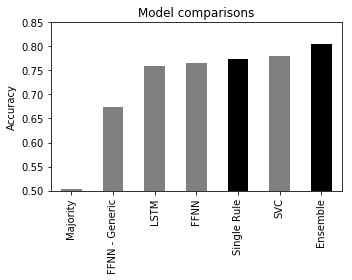

In [23]:
benchmarks = pd.Series([.504, .6734, .76, .7657, .773, .78, .804], 
                       index=["Majority", "FFNN - Generic", "LSTM", 
                              "FFNN", "Single Rule", "SVC", "Ensemble"])
benchmarks.plot(kind="bar", color=["0.5", "0.5", "0.5", 
                                   "0.5", "k", "0.5", "k"], figsize=(5,4))
plt.ylim(.5, .85)
plt.title("Model comparisons")
plt.ylabel("Accuracy")
plt.tight_layout()
plt.savefig("figures/comparisons.jpeg")